In [108]:
import numpy as np
import matplotlib.pyplot as plt #  pip install matplotlib==2.2.3
from sklearn import manifold, datasets
import pandas as pd
import torch
from model import HTML_NN
from normalize_parameter import F_MEANS, F_STDS


In [109]:
#load data
df = pd.read_csv('df_processed.csv')
df_sta = pd.read_csv('data/status.csv')

# Clean column
df = df.set_index('Customer ID')
df_sta['Churn Category'] = df_sta['Churn Category'].map({'No Churn':0,'Competitor':1,'Dissatisfaction':2,'Attitude':3,'Price':4,'Other':5})
df_train = df.reindex(df_sta['Customer ID'])
df_sta = df_sta.set_index('Customer ID')

print(df_train)
print(df_sta)

y = df_sta.to_numpy().ravel()
X = df_train.to_numpy()

# Normalizize Input data
for r_idx in range(X.shape[0]):
    for f_idx in range(X.shape[1]):
        X[r_idx][f_idx] = (X[r_idx][f_idx].item() - F_MEANS[f_idx])/F_STDS[f_idx]

# print(X.shape)
# print(y.shape)

               Gender        Age   Married  Number of Dependents  Zip Code  \
Customer ID                                                                  
0650-BWOZN   1.000000  37.000000  0.053040              0.000000  5.381173   
0562-FGDCR   0.504743  54.000000  0.000000              0.000000  4.000000   
6688-UZPWD   1.000000  42.429886  1.014237              1.188874  3.000000   
2905-KFQUV   1.000000  23.000000  0.000000              0.000000  3.000000   
9720-JJJOR   0.000000  41.000000  1.000000              0.000000  4.000000   
...               ...        ...       ...                   ...       ...   
3313-QKNKB   1.000000  23.000000  0.019045              0.463649  4.372484   
8668-KNZTI   0.517537  41.775967  0.334268              0.676197  2.000000   
8809-RIHDD   1.000000  60.000000  0.000000              2.000000  3.289211   
6663-JOCQO   0.000000  44.122419  0.000000              3.000000  4.000000   
7010-ZMVBF   0.518690  71.000000  1.000000              0.000000

In [110]:
def valid(model, Xs, ys):
    model.eval()
    tp = [0,0,0,0,0,0] # True positive
    fp = [0,0,0,0,0,0] # Fasle Positive
    fn = [0,0,0,0,0,0] # False Negative
    with torch.no_grad():
        for i, data in enumerate(Xs):
            y = model(data)
            pred = y.max(0, keepdim=True)[1] # get the index of the max log-probability
            if pred.item() == ys[i]: # Debug
                tp[pred.item()] += 1
            else:
                fp[pred.item()] += 1
                fn[ys[i]] += 1
        
        # Calcuate f1-score for each class
        f_score_list = []
        for c in range(6):
            try:
                precision = tp[c]/(tp[c] + fp[c])
                recall    = tp[c]/(tp[c] + fn[c])
                f_score = 2*precision*recall/(precision + recall)
            except:
                f_score = 0
            f_score_list.append(f_score)
            print(f"f_score for class {c} = {f_score}")
        print(f"Avg f1 score: {sum(f_score_list)/len(f_score_list)}")
    return sum(f_score_list)/len(f_score_list)

In [111]:
X_train = torch.from_numpy(X)
X_train = X_train.float()

model = HTML_NN().to("cpu")
model.load_state_dict(torch.load("best.pth")['state_dict'])
model.eval()

print(model)
feature_dic = {}
def get_activation(name):
    def hook(model, input, output):
        feature_dic[name] = output.detach()
    return hook
model.mlp[9].register_forward_hook(get_activation('features'))

# Validation
valid(model, X_train, y)

# 
X = model(X_train)
# print(X.shape)
X = X.detach().numpy()

# print(feature_dic['features'].shape)  #  .to("cpu").numpy()[0])
X_features = feature_dic['features'].detach().numpy()
print(X_features.shape)


HTML_NN(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=43, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=43, out_features=43, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=43, out_features=20, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=10, out_features=6, bias=True)
    (9): ReLU(inplace=True)
  )
)
f_score for class 0 = 0.9250601581299416
f_score for class 1 = 0.8172413793103449
f_score for class 2 = 0.8284313725490197
f_score for class 3 = 0.7594433399602386
f_score for class 4 = 0.8135593220338982
f_score for class 5 = 0.8507462686567163
Avg f1 score: 0.8324136401066933
(4226, 6)


Number of samples: 4226
Number of n_features: 6
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4226 samples in 0.003s...
[t-SNE] Computed neighbors for 4226 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4226
[t-SNE] Computed conditional probabilities for sample 2000 / 4226
[t-SNE] Computed conditional probabilities for sample 3000 / 4226
[t-SNE] Computed conditional probabilities for sample 4000 / 4226
[t-SNE] Computed conditional probabilities for sample 4226 / 4226
[t-SNE] Mean sigma: 1.493531


/home/spiderkiller/miniconda3/envs/html/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.336945
[t-SNE] KL divergence after 1000 iterations: 0.878662


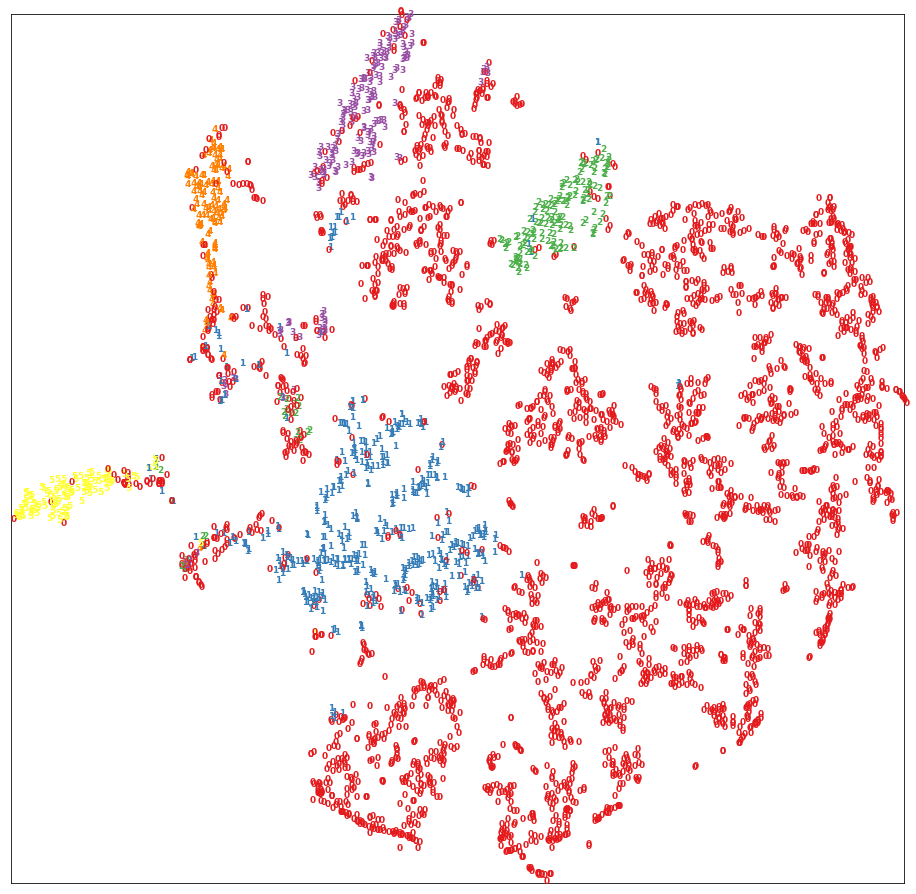

In [112]:
n_samples, n_features = X_features.shape
print(f"Number of samples: {n_samples}")
print(f"Number of n_features: {n_features}")

#t-SNE
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X_features)

#Data Visualization
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
plt.figure(figsize=(16, 16))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()
